# Food Delivery Time Prediction Model

## Libraries Used for the Project

In [1]:

# importing library used in the project
import pandas as pd
import statsmodels.api as sm # For Variance Infaltion Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor # For Variance Infaltion Factor (VIF)

import numpy as np

import janitor # For Data Cleaning

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error # For MAE evaluation
from sklearn.metrics import root_mean_squared_error # For RMSE evaluation
from sklearn.metrics import r2_score # For R2 evaluation

import seaborn as sns

import geopy # For feature engineering calculation distance using coordinates
from geopy.distance import geodesic

import warnings
warnings.filterwarnings("ignore")

## Read & Prepare Data

In [2]:

# Load the data to python and check the data through sample
df = pd.read_csv('Food_Delivery_Time_Dataset.csv')
df.sample(4)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
11600,0x8a11,MUMRES08DEL01,35,4.9,19.065838,72.832658,19.135838,72.902658,04-03-2022,17:10:00,17:15:00,conditions Cloudy,Medium,0,Meal,motorcycle,1,No,Metropolitian,(min) 43
2676,0x9ce5,PUNERES20DEL02,33,5,18.592718,73.773572,18.642718,73.823572,15-03-2022,22:35:00,22:50:00,conditions Stormy,Low,1,Snack,scooter,0,No,Urban,(min) 29
41790,0xa4f9,RANCHIRES010DEL03,31,5,23.354422,85.332900,23.384422,85.362900,30-03-2022,19:40:00,19:45:00,conditions Sandstorms,Jam,2,Snack,motorcycle,1,No,Metropolitian,(min) 34
3115,0xcf35,KOLRES18DEL01,22,4.7,22.569367,88.433187,22.609367,88.473187,13-02-2022,15:35:00,15:50:00,conditions Windy,Medium,2,Drinks,motorcycle,1,No,Urban,(min) 27


In [3]:

# Check for data structure and type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [4]:

# Check for the number of rows and columns
df.shape

(45593, 20)

In [5]:

# Preliminary preparation

# Standardize the column name
df_clean = df.clean_names()

# Change column name to improve readability
df_clean = df_clean.rename(columns={'time_orderd': 'time_ordered', 'weatherconditions': 'weather_conditions'}) 

# Remove the substring "condition " from the weather_conditions column
df_clean['weather_conditions'] = df_clean['weather_conditions'].str.replace('conditions ', '', regex=False)

# Remove the substring "(min) " from the time_taken_min_ column
df_clean['time_taken_min_'] = df_clean['time_taken_min_'].str.replace('(min) ', '', regex=False)

# Remove whitespace in data
df_clean = df_clean.map(lambda x: x.strip() if isinstance(x, str) else x)

In [6]:

# check for duplicate row
print(df_clean.duplicated().sum())

0


In [9]:

# Deleting row that contain "Nan"

# Identify cells containing the string "NaN"
nan_mask = df_clean.map(lambda x: x == 'NaN')

# Filter out rows where any cell contains the string "NaN"
df_clean = df_clean[~nan_mask.any(axis=1)]

In [10]:

# Changing Dtypes to appropriate type 

df_clean['delivery_person_age'] = df_clean['delivery_person_age'].astype('int64')

df_clean['delivery_person_ratings'] = df_clean['delivery_person_ratings'].astype('float64')

df_clean['order_date'] = pd.to_datetime(df_clean['order_date'], format = '%d-%m-%Y', errors='coerce')

df_clean['time_ordered'] =  pd.to_timedelta(df_clean['time_ordered'])

df_clean['time_order_picked'] =  pd.to_timedelta(df_clean['time_order_picked'])

df_clean['vehicle_condition'] = df_clean['vehicle_condition'].astype('object')

df_clean['time_taken_min_'] = df_clean['time_taken_min_'].astype('int64')

df_clean.info() # Check if Dtypes changes success

<class 'pandas.core.frame.DataFrame'>
Index: 41368 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   id                           41368 non-null  object         
 1   delivery_person_id           41368 non-null  object         
 2   delivery_person_age          41368 non-null  int64          
 3   delivery_person_ratings      41368 non-null  float64        
 4   restaurant_latitude          41368 non-null  float64        
 5   restaurant_longitude         41368 non-null  float64        
 6   delivery_location_latitude   41368 non-null  float64        
 7   delivery_location_longitude  41368 non-null  float64        
 8   order_date                   41368 non-null  datetime64[ns] 
 9   time_ordered                 41368 non-null  timedelta64[ns]
 10  time_order_picked            41368 non-null  timedelta64[ns]
 11  weather_conditions           4136

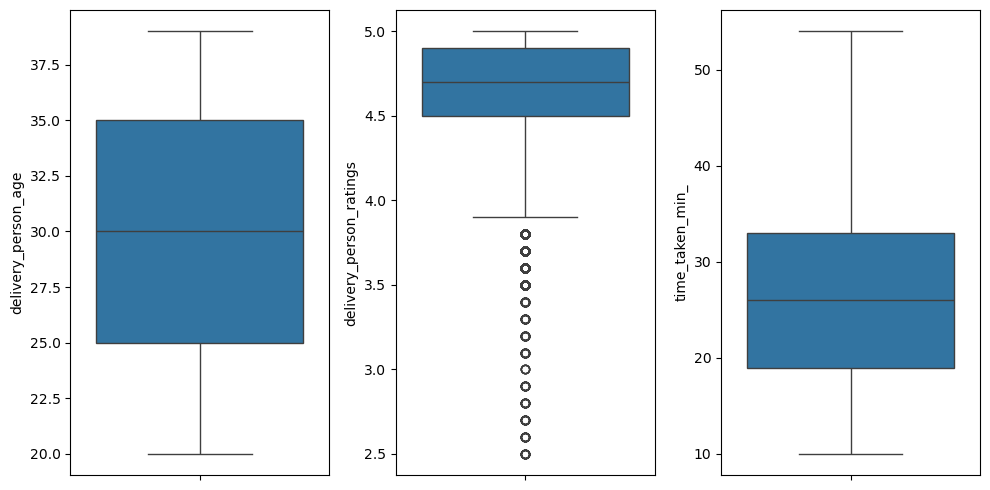

In [11]:

# Handling outlier (1)

# Using box plot to check for outlier
selected_cols = ['delivery_person_age', 'delivery_person_ratings', 'time_taken_min_']

plt.figure(figsize = (10,5))
for i in range(len(selected_cols)):
    plt.subplot(1,len(selected_cols),i+1)
    sns.boxplot(df_clean[selected_cols[i]], orient = "v")
    plt.tight_layout()

In [12]:

# Handling outlier (2)

# Using IQR method for 'delivery_person_age' 
q1_age = df_clean['delivery_person_age'].quantile(0.25)
q3_age = df_clean['delivery_person_age'].quantile(0.75)

iqr_age = q3_age-q1_age 
fence_low_age  = q1_age-1.5*iqr_age
fence_high_age = q3_age+1.5*iqr_age

# Filter out row that have outlier for 'delivery_person_age'
df_clean = df_clean[(df_clean['delivery_person_age'] >= fence_low_age) & (df_clean['delivery_person_age'] <= fence_high_age)]


# Using IQR method for 'delivery_person_ratings' 
q1_delivery = df_clean['delivery_person_ratings'].quantile(0.25)
q3_delivery = df_clean['delivery_person_ratings'].quantile(0.75)

iqr_delivery = q3_delivery-q1_delivery 
fence_low_delivery  = q1_delivery-1.5*iqr_delivery
fence_high_delivery = q3_delivery+1.5*iqr_delivery

# Filter out row that have outlier for 'delivery_person_ratings'
df_clean = df_clean[(df_clean['delivery_person_ratings'] >= fence_low_delivery) & (df_clean['delivery_person_ratings'] <= fence_high_delivery)]


# Using IQR method for 'time_taken_min_' 
q1_time = df_clean['time_taken_min_'].quantile(0.25)
q3_time = df_clean['time_taken_min_'].quantile(0.75)

iqr_time = q3_time-q1_time 
fence_low_time  = q1_time-1.5*iqr_time
fence_high_time = q3_time+1.5*iqr_time

# Filter out row that have outlier for 'delivery_person_ratings'
df_clean = df_clean[(df_clean['time_taken_min_'] >= fence_low_time) & (df_clean['time_taken_min_'] <= fence_high_time)]

In [13]:

# Handling abnormal value (1)

# Filter out abnormal restaurant coordinate (0,0) which is null island (https://en.wikipedia.org/wiki/Null_Island)
df_clean=df_clean.query('restaurant_latitude != 0 & restaurant_longitude != 0')

In [15]:

# Handling abnormal value (2)

# Check 'delivery_person_age' for abnormal values
df_clean['delivery_person_age'].describe()

count    36822.000000
mean        29.529222
std          5.762479
min         20.000000
25%         25.000000
50%         30.000000
75%         35.000000
max         39.000000
Name: delivery_person_age, dtype: float64

In [14]:

# Handling abnormal value (3)

# Check 'delivery_person_ratings' for abnormal values
df_clean['delivery_person_ratings'].describe()

count    36822.000000
mean         4.663565
std          0.254925
min          3.900000
25%          4.600000
50%          4.700000
75%          4.900000
max          5.000000
Name: delivery_person_ratings, dtype: float64

## FEATURE ENGINEERING

In [20]:

# Calculating distance using the restaurant and delivery location coordinates utilising the geopy library
df_clean['distance_km'] = df_clean[['restaurant_latitude', 
                                    'restaurant_longitude', 
                                    'delivery_location_latitude', 
                                    'delivery_location_longitude']].apply(
    lambda row: geodesic(row[0:2], row[2:4]).km, axis=1)

In [16]:

# Generate name of the day from date
df_clean['day_name'] = df_clean['order_date'].dt.day_name()

# Create a new column for weekday/weekend label
weekend = [('Weekend' if day in ['Saturday', 'Sunday'] else 'Weekday') for day in df_clean['day_name']]
df_clean['day_type'] = weekend

In [17]:

# Calculate pickup_period
df_clean['pickup_period'] = df_clean['time_order_picked'] - df_clean['time_ordered']

df_clean['pickup_period'] = df_clean['pickup_period'].apply(lambda x: x + pd.Timedelta(days=1) if x < pd.Timedelta(days=0) else x)

In [18]:

# Grouping the order time

# Function to create label
def label_time(td):
    total_seconds = td.total_seconds()
    hours = (total_seconds // 3600) % 24  # Extract hours from timedelta
    if 6 <= hours < 12:
        return 'Breakfast'
    elif 12 <= hours < 16:
        return 'Lunch'
    elif 16 <= hours < 21:
        return 'Dinner'
    else:
        return 'Late Night'

# Apply the function to create a new column
df_clean['ordered_class'] = df_clean['time_ordered'].apply(label_time)

In [21]:

# Handling outlier for numeric feature 

# Using IQR method for 'distance_km' 
q1_dist = df_clean['distance_km'].quantile(0.25)
q3_dist = df_clean['distance_km'].quantile(0.75)

iqr_dist = q3_dist-q1_dist 
fence_low_dist  = q1_dist-1.5*iqr_dist
fence_high_dist = q3_age+1.5*iqr_dist

# Filter out row that have outlier for 'distance_km'
df_clean = df_clean[(df_clean['distance_km'] >= fence_low_dist) & (df_clean['distance_km'] <= fence_high_dist)]


df_clean['distance_km'].describe()

count    36682.000000
mean         9.601562
std          5.582102
min          1.463837
25%          4.647989
50%          9.160879
75%         13.592749
max         20.942906
Name: distance_km, dtype: float64

In [22]:

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36682 entries, 0 to 45592
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   id                           36682 non-null  object         
 1   delivery_person_id           36682 non-null  object         
 2   delivery_person_age          36682 non-null  int64          
 3   delivery_person_ratings      36682 non-null  float64        
 4   restaurant_latitude          36682 non-null  float64        
 5   restaurant_longitude         36682 non-null  float64        
 6   delivery_location_latitude   36682 non-null  float64        
 7   delivery_location_longitude  36682 non-null  float64        
 8   order_date                   36682 non-null  datetime64[ns] 
 9   time_ordered                 36682 non-null  timedelta64[ns]
 10  time_order_picked            36682 non-null  timedelta64[ns]
 11  weather_conditions           3668

## One Hot Encoding for Object Type Feature

In [141]:

# Prepare one hot encoding for column with 'Object' Dtypes (1)

# Dropping unused column from df_clean
df_clean.drop(['id', 'delivery_person_id', 'delivery_person_age', 'restaurant_latitude', 'restaurant_longitude', 'delivery_location_latitude', 'delivery_location_longitude', 'order_date', 'time_ordered', 'time_order_picked', 'day_name'], axis = 1, inplace = True)


In [142]:

# Prepare one hot encoding for column with 'Object' Dtypes (2)

# One Hot Encoding
df_object = df_clean.select_dtypes(["object"])
obj_cols = list(df_object.columns)

df_result = pd.get_dummies(df_clean, columns = obj_cols)

df_result.sample (5)


,delivery_person_ratings,time_taken_min_,distance_km,pickup_period,weather_conditions_Cloudy,weather_conditions_Fog,weather_conditions_Sandstorms,weather_conditions_Stormy,weather_conditions_Sunny,weather_conditions_Windy,...,festival_Yes,city_Metropolitian,city_Semi-Urban,city_Urban,day_type_Weekday,day_type_Weekend,ordered_class_Breakfast,ordered_class_Dinner,ordered_class_Late Night,ordered_class_Lunch
20023,4.7,23,3.054414,0 days 00:15:00,False,False,False,False,True,False,...,False,True,False,False,True,False,True,False,False,False
10752,4.7,17,1.518098,0 days 00:15:00,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
8451,4.3,37,13.661065,0 days 00:15:00,False,False,False,False,False,True,...,False,True,False,False,True,False,False,True,False,False
22200,4.6,15,3.098575,0 days 00:15:00,False,False,False,False,True,False,...,False,False,False,True,True,False,True,False,False,False
38214,4.7,29,4.654235,0 days 00:05:00,False,False,False,False,False,True,...,False,True,False,False,True,False,False,True,False,False


## Feature Selection

In [143]:

# Selecting features with correlation more than 0.1 or -0.1 to the time_taken_min_
correlation_matrix = df_result.corr()
target_variable = 'time_taken_min_'
target_correlation = correlation_matrix[target_variable].abs()
selected_features = target_correlation[target_correlation > 0.1].index.tolist()
df_selected = df_result[selected_features]

print(df_selected.columns)

Index(['delivery_person_ratings', 'time_taken_min_', 'distance_km',
       'weather_conditions_Cloudy', 'weather_conditions_Fog',
       'weather_conditions_Sunny', 'road_traffic_density_Jam',
       'road_traffic_density_Low', 'vehicle_condition_0',
       'vehicle_condition_1', 'vehicle_condition_2',
       'type_of_vehicle_motorcycle', 'type_of_vehicle_scooter',
       'multiple_deliveries_0', 'multiple_deliveries_2',
       'multiple_deliveries_3', 'festival_No', 'festival_Yes',
       'city_Metropolitian', 'city_Semi-Urban', 'city_Urban',
       'ordered_class_Breakfast', 'ordered_class_Dinner'],
      dtype='object')


In [144]:

# Variance Inflation Factor (VIF)

# Select numerical predictors
numerical_predictors = ['delivery_person_ratings', 'distance_km']

# Prepare the data for VIF calculation
calc_vif = df_clean[numerical_predictors]

# Add a constant for intercept (for VIF calculation)
calc_vif = sm.add_constant(calc_vif)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Predictor'] = calc_vif.columns
vif_data['VIF'] = [variance_inflation_factor(calc_vif.values, i) for i in range(calc_vif.shape[1])]

print(vif_data)

                 Predictor         VIF
0                    const  341.626412
1  delivery_person_ratings    1.001642
2              distance_km    1.001642


##### Based on the VIF calculation result there is no multicollinearity issues for the numeric feature used in the model

## Split Train Test Data

In [145]:

# Splitting Train Test
y = df_selected['time_taken_min_']
X = df_selected.drop(columns = ['time_taken_min_'])

# stratified random splitting X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                            random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(29345, 22)
(7337, 22)
(29345,)
(7337,)


## Modelling

### Linear Regression Modelling

In [146]:

# Create linear regression object
linear_reg = linear_model.LinearRegression()

# Fit the model
linear_reg.fit(X_train, y_train)

# Coefficients and Intercept
print('Coefficients: ', linear_reg.coef_)
print('Intercept: ', linear_reg.intercept_)

Coefficients:  [-7.26159399  0.33289318  2.50123382  2.51327489 -3.66061277  2.02698656
 -5.65924127  2.83339116 -1.44203592 -1.39135524  0.09017712  0.17085035
 -2.17532602  6.96524822 10.58045983 -4.54479008  4.54479008 -2.23750959
  6.63474479 -4.39723519  1.58464663 -0.61234263]
Intercept:  65.08582948415419


### Linear Regression Model Evaluation

In [147]:

# Fit the test data into model
y_pred = linear_reg.predict(X_test)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
RMSE = root_mean_squared_error(y_test, y_pred)

# R2
r2 = r2_score(y_test, y_pred)


# Print the result
print('MAE  : ', MAE)
print('RMSE : ', RMSE)
print('R2   : ', r2)

MAE  :  4.99676718121081
RMSE :  6.181564862384472
R2   :  0.53411528148029


### Ridge Regression Modelling with Hyperparameter Tuning

In [148]:

# Create ridge regression object 
ridge_reg = Ridge()

# Define the hyperparameter grid
params = {'alpha': np.logspace(-4, 4, 50)}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator = ridge_reg, param_grid = params, scoring = 'neg_mean_squared_error', cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_ridge = grid_search.best_estimator_

# Print the best alpha value
print(f"Best alpha: {grid_search.best_params_['alpha']}")

# Coefficients and Intercept
print('Coefficients: ', best_ridge.coef_)
print('Intercept: ', best_ridge.intercept_)

Best alpha: 0.3906939937054613
Coefficients:  [-7.2604545   0.3329064   2.50126013  2.51325021 -3.6605595   2.0274577
 -5.65885526  2.83355213 -1.44213906 -1.39141307  0.09035694  0.17082309
 -2.17556764  6.96300204 10.5604515  -4.54449626  4.54449626 -2.22671595
  6.61303354 -4.38631759  1.58443398 -0.61205255]
Intercept:  65.06919070641854


### Ridge Regression Model Evaluation

In [149]:

# Fit the test data into model
y_pred = best_ridge.predict(X_test)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
RMSE = root_mean_squared_error(y_test, y_pred)

# R2
r2 = r2_score(y_test, y_pred)


# Print the result
print('MAE  : ', MAE)
print('RMSE : ', RMSE)
print('R2   : ', r2)

MAE  :  4.996794514926257
RMSE :  6.181576480946274
R2   :  0.534113530171163


### Lasso Regression Modelling with Hyperparameter Tuning

In [150]:

# Create lasso regression object 
lasso_reg = Lasso()

# Define the hyperparameter grid
params = {'alpha': np.logspace(-4, 4, 50)}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator = lasso_reg, param_grid = params, scoring = 'neg_mean_squared_error', cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_lasso = grid_search.best_estimator_

# Print the best alpha value
print(f"Best alpha: {grid_search.best_params_['alpha']}")

# Coefficients and Intercept
print('Coefficients: ', best_lasso.coef_)
print('Intercept: ', best_lasso.intercept_)

Best alpha: 0.0004498432668969444
Coefficients:  [-7.25720509  0.33273771  2.4988477   2.51071239 -3.65969782  2.02753129
 -5.6545875   4.22888307 -0.04587308 -0.          0.07578265  0.15576828
 -2.17505118  6.95785515 10.52579242 -9.07689453  0.          0.
  8.70149747 -2.15837403  1.57880633 -0.60794954]
Intercept:  65.97960715475591


### Lasso Regression Model Evaluation

In [151]:

# Fit the test data into model
y_pred = best_lasso.predict(X_test)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
RMSE = root_mean_squared_error(y_test, y_pred)

# R2
r2 = r2_score(y_test, y_pred)


# Print the result
print('MAE  : ', MAE)
print('RMSE : ', RMSE)
print('R2   : ', r2)


MAE  :  4.996885811673846
RMSE :  6.181672314618077
R2   :  0.5340990846790548


### Random Forest Regression Model with Hyperparameter Tuning

In [163]:

# Create Random Forest regressor object
rf_reg = RandomForestRegressor()

# Define the hyperparameter grid
params = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],           # Number of features to consider at every split
    'max_depth': [10, 20, 30, 40, 50, None],    # Maximum number of levels in each decision tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]                  # Method of selecting samples for training each tree
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_reg, param_distributions=params, 
                                   n_iter=100, scoring='neg_mean_squared_error', cv=5, 
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best model
best_rf = random_search.best_estimator_

# Print the best parameters
print(f"Best parameters: {random_search.best_params_}")

# Feature Importance
print('Feature Importances: ', best_rf.feature_importances_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Feature Importances:  [0.19666353 0.15522642 0.05164137 0.05313432 0.06188444 0.06240825
 0.11876596 0.07104236 0.00964912 0.00791774 0.00954222 0.0040382
 0.02644965 0.0598794  0.00935695 0.02551788 0.02563566 0.00748195
 0.00171579 0.00998939 0.00949282 0.02256659]


### Random Forest Regression Model Evaluation

In [164]:

# Fit the test data into model
y_pred = best_rf.predict(X_test)

# Evaluating Model
MAE = mean_absolute_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Print the result
print('MAE  : ', MAE)
print('RMSE : ', RMSE)
print('R2   : ', r2)

MAE  :  3.813071208216256
RMSE :  4.844491149136784
R2   :  0.7122203374471763


## Split Train Test Data (Stratified Random Sampling)

In [152]:

# Splitting Train Test
y = df_selected['time_taken_min_']
X = df_selected.drop(columns = ['time_taken_min_'])

# Define the number of quantiles (strata)
n_quantiles = 13

# Create quantile groups
qcuts = pd.qcut(df_selected['time_taken_min_'], n_quantiles, labels = False)

# Stratified split using quantile groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                  stratify = qcuts,
                                                  random_state = 42)


### Linear Regression Modelling (Stratified)

In [153]:

# Create linear regression object
linear_reg = linear_model.LinearRegression()

# Fit the model
linear_reg.fit(X_train, y_train)

# Coefficients and Intercept
print('Coefficients: ', linear_reg.coef_)
print('Intercept: ', linear_reg.intercept_)

Coefficients:  [-7.35637699  0.33944766  2.59254685  2.5523418  -3.52225653  2.01197053
 -5.61595596  2.84300908 -1.42090591 -1.42210317  0.0833094   0.17085327
 -2.20421403  6.99885445 10.45197293 -4.65618617  4.65618617 -2.29938931
  6.66827511 -4.3688858   1.62272746 -0.63119681]
Intercept:  65.55774404418847


### Linear Regression Modelling (Stratified) Evaluation

In [154]:

# Fit the test data into model
y_pred = linear_reg.predict(X_test)

# Evaluating Model
MAE = mean_absolute_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Print the result
print('MAE  : ', MAE)
print('RMSE : ', RMSE)
print('R2   : ', r2)


MAE  :  4.869066817619107
RMSE :  6.059298286740979
R2   :  0.5497969526781332


### Ridge Regression Modelling (STratified) with Hyperparameter Tuning

In [155]:

# Create ridge regression object 
ridge_reg = Ridge()

# Define the hyperparameter grid
params = {'alpha': np.logspace(-4, 4, 50)}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator = ridge_reg, param_grid = params, scoring = 'neg_mean_squared_error', cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_ridge = grid_search.best_estimator_

# Print the best alpha value
print(f"Best alpha: {grid_search.best_params_['alpha']}")

# Coefficients and Intercept
print('Coefficients: ', best_ridge.coef_)
print('Intercept: ', best_ridge.intercept_)

Best alpha: 0.0001
Coefficients:  [-7.35637669  0.33944766  2.59254687  2.55234179 -3.52225652  2.01197065
 -5.61595586  2.84300887 -1.42090619 -1.42210345  0.08330946  0.17085327
 -2.20421409  6.99885388 10.45196776 -4.65618606  4.65618606 -2.29938615
  6.66826938 -4.36888261  1.62272741 -0.63119673]
Intercept:  65.55773953383252


### Ridge Regression Modelling (Stratified) Evaluation

In [156]:

# Fit the test data into model
y_pred = best_ridge.predict(X_test)

# Evaluating Model
MAE = mean_absolute_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Print the result
print('MAE  : ', MAE)
print('RMSE : ', RMSE)
print('R2   : ', r2)

MAE  :  4.869066827463705
RMSE :  6.059298288260466
R2   :  0.5497969524523387


### Lasso Regression Modelling (Stratified) with Hyperparameter Tuning

In [157]:

# Create lasso regression object 
lasso_reg = Lasso()

# Define the hyperparameter grid
params = {'alpha': np.logspace(-4, 4, 50)}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator = lasso_reg, param_grid = params, scoring = 'neg_mean_squared_error', cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_lasso = grid_search.best_estimator_

# Print the best alpha value
print(f"Best alpha: {grid_search.best_params_['alpha']}")

# Coefficients and Intercept
print('Coefficients: ', best_lasso.coef_)
print('Intercept: ', best_lasso.intercept_)

Best alpha: 0.0001
Coefficients:  [-7.35538294e+00  3.39417507e-01  2.59206535e+00  2.55178368e+00
 -3.52205064e+00  2.01207881e+00 -5.61494229e+00  4.26400285e+00
 -0.00000000e+00 -1.57478194e-03  8.05791568e-02  1.67844870e-01
 -2.20414889e+00  6.99718581e+00  1.04398143e+01 -9.30913063e+00
  0.00000000e+00  1.94433731e+00  1.08717321e+01 -1.24864486e-01
  1.62147489e+00 -6.30211565e-01]
Intercept:  64.54418592199266


### Lasso Regression Modelling (Stratified) Evaluation

In [159]:

# Fit the test data into model
y_pred = best_lasso.predict(X_test)

# Evaluating Model
MAE = mean_absolute_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Print the result
print('MAE  : ', MAE)
print('RMSE : ', RMSE)
print('R2   : ', r2)

MAE  :  4.8690827428422665
RMSE :  6.059297498975968
R2   :  0.5497970697392742


### Random Forest Regression Model (Stratified) with Hyperparameter Tuning

In [161]:

# Create Random Forest regressor object
rf_reg = RandomForestRegressor()

# Define the hyperparameter grid
params = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],           # Number of features to consider at every split
    'max_depth': [10, 20, 30, 40, 50, None],    # Maximum number of levels in each decision tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]                  # Method of selecting samples for training each tree
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_reg, param_distributions=params, 
                                   n_iter=100, scoring='neg_mean_squared_error', cv=5, 
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best model
best_rf = random_search.best_estimator_

# Print the best parameters
print(f"Best parameters: {random_search.best_params_}")

# Feature Importance
print('Feature Importances: ', best_rf.feature_importances_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Feature Importances:  [0.1938095  0.1564415  0.05067141 0.05250704 0.06005082 0.06393005
 0.11898302 0.07108212 0.00994352 0.0080251  0.00910238 0.00444975
 0.0267356  0.06009892 0.00890827 0.02456572 0.02816139 0.0080384
 0.00162502 0.00968385 0.00880857 0.02437803]


### Random Forest Regression Model (Stratified) Evaluation

In [162]:

# Fit the test data into model
y_pred = best_rf.predict(X_test)

# Evaluating Model
MAE = mean_absolute_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Print the result
print('MAE  : ', MAE)
print('RMSE : ', RMSE)
print('R2   : ', r2)

MAE  :  3.81218263830449
RMSE :  4.845261814243267
R2   :  0.7121287697765766
